# STAT778: Final Project

In [1]:
import numpy as np
from numpy.random import uniform, normal, multivariate_normal, exponential, gamma
import scipy as sc
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
#it's not quite this. 3.2 does some sort of learning. how?
#we're measuring the likelihood (via the pdf) of x given our parameters and the result.
#THEN we combine that with our prior.
#Then we have a posterior belief about how possible these parameters are given the data we just saw and our prior belief.
#now we binarize this belief stochastically! and move onto the next iteration.

## Metropolis-Hastings with a Bayesian Linear Model

In [158]:
#metropolis-hastings functions
def sample(data: np.ndarray, N: int, B: int, start_theta: tuple, search_breadth: float=0.5):
    """Takes N samples via the Metropolis-Hastings algorithm, with B burn-in samples."""
    theta = start_theta
    for b in range(B): #burnin samples
        results = step(data, theta, search_breadth)
        theta = results['theta']
    
    samples = []
    for n in range(N): #real samples
        results = step(data, theta, search_breadth)
        theta = results['theta']
        samples.append(results)
    return samples

def step(data: np.ndarray, theta: tuple, search_breadth: float):
    """Takes one step in the Metropolis-Hastings algorithm by generating a new theta and comparing to a given theta."""
    theta_prime = sample_theta(theta, search_breadth) #sample a new set of parameters
    #print(f"sampled theta_prime as: {theta_prime}")
    acceptance_log_prob = min(1,calc_acceptance_prob(theta, theta_prime, data, search_breadth)) #calculate the probability of acceptance
    accepted = np.exp(acceptance_log_prob) >= uniform() #probabilistically determine acceptance 
    return {'accepted': accepted, 'acceptance_prob': np.exp(acceptance_log_prob), 'theta': theta_prime if accepted else theta} #return results, update theta if samples accepted

def sample_theta(theta: tuple, search_breadth: float):
    """Samples theta parameters--slope, intercept, and standard deviation."""
    a,b,sigma = theta
    a,b = multivariate_normal([a,b], [[search_breadth**2,0],[0,search_breadth**2]])
    sigma = gamma(sigma*search_breadth*500, 1/(search_breadth*500))
    theta = a,b,sigma
    return theta

def calc_acceptance_prob(theta: tuple, theta_prime: tuple, data: np.ndarray, search_breadth: float):
    """Calculates acceptance probability by using a Bayesian linear model."""
    theta_likelihood = likelihood(theta, data)
    theta_prior = prior(theta)
    #print(f"theta likelihood: {theta_likelihood}\ttheta prior: {theta_prior}")
    
    theta_p_likelihood = likelihood(theta_prime, data)
    theta_p_prior = prior(theta_prime)
    #print(f"theta prime likelihood: {theta_p_likelihood}\ttheta prime prior: {theta_p_prior}")
    
    
    pr = proposal_ratio(theta, theta_prime, search_breadth)
    acceptance_ratio = theta_p_likelihood - theta_likelihood + theta_p_prior - theta_prior + pr
    #print(f"proposal ratio: {pr}")
    #print(f"acceptance ratio: {acceptance_ratio}")
    return acceptance_ratio

#bayesian functions
def likelihood(theta: tuple, data: np.ndarray):
    """Calculates the likelihood component of our linear model by measuring our parameters theta on the given data."""
    a,b,sigma = theta
    x,y = data[0],data[1]
    likelihoods = sc.stats.norm.logpdf(y, loc=a*x+b, scale=sigma) #find the likelihood of a sample given a normal distribution specified by our parameters and the data
    return np.sum(likelihoods) #use log likelihood for stability

def prior(theta: tuple):
    """Calculates the prior component of our linear model, specified """
    a,b,sigma = theta
    ab_prior = sc.stats.multivariate_normal.logpdf([a,b], [0,0], [[100,0],[0,100]]) #cov defaults to 1
    sigma_prob = sc.stats.gamma.logpdf(sigma, 1, 1)
    return np.sum([ab_prior,sigma_prob])

def proposal_ratio(theta: tuple, theta_prime: tuple, search_breadth: float):
    """Offsets bidirectionality of chained samples."""
    a,b,sigma = theta
    a_p,b_p,sigma_p = theta_prime
    old_given_new_ab = sc.stats.multivariate_normal.logpdf([a,b],[a_p,b_p],[[search_breadth**2,0],[0,search_breadth**2]])
    old_given_new_sigma = sc.stats.gamma.logpdf(sigma, sigma_p*search_breadth*500, scale=1/(500*search_breadth))
    old_given_new = old_given_new_ab + old_given_new_sigma
    
    new_given_old_ab = sc.stats.multivariate_normal.logpdf([a_p,b_p],[a,b],[[search_breadth**2,0],[0,search_breadth**2]])
    new_given_old_sigma = sc.stats.gamma.logpdf(sigma_p, sigma*search_breadth*500, scale=1/(500*search_breadth))
    new_given_old = new_given_old_ab - new_given_old_sigma
    
    #print(f"ogn: {old_given_new}\tngo: {new_given_old}")
    return old_given_new - new_given_old

In [159]:
X = np.random.rand(10000)
Y = np.random.normal(4,2,10000)
data = np.vstack((X,Y))
step(data,(4,0,2),0.5)

{'accepted': False, 'acceptance_prob': 0.0, 'theta': (4, 0, 2)}

## Zero Case: N(0,1)

In [ ]:
X = np.random.rand(10000)
Y = np.random.normal(0,1,10000)
data = np.vstack((X,Y))
samples = sample(data, 30000, 0, (0,0,1), 1)
df = pd.DataFrame(samples)
df[['a','b','sigma']] = pd.DataFrame(df['theta'].tolist(), index=df.index)
df = df.drop(['theta'], axis=1)

In [ ]:
plt.scatter(X,Y)
plt.xlabel("X")
plt.ylabel("Y")
plt.title("The Data")

In [ ]:
df

In [ ]:
plt.plot(range(len(df)),df['a'], label='slope')
plt.plot(range(len(df)),df['b'], label='intercept')
plt.plot(range(len(df)),df['sigma'], label='variance')
plt.plot(range(len(df)),df['acceptance_prob'], label='accept_prob')
plt.xlabel("Time Steps")
plt.ylabel("Values")
plt.legend()

In [ ]:
plt.plot(range(len(df)),df['acceptance_prob'], label='accept_prob')
plt.xlabel("Time Steps")
plt.ylabel("Values")
plt.legend()

## Nonzero Case: N(4,2)

In [178]:
X = np.random.rand(10000)
Y = np.random.normal(-13,8,10000)
data = np.vstack((X,Y))
samples = sample(data, 20000, 0, (0,4,2), 0.2)
df = pd.DataFrame(samples)
df[['a','b','sigma']] = pd.DataFrame(df['theta'].tolist(), index=df.index)
df = df.drop(['theta'], axis=1)

Text(0.5, 1.0, 'The Data')

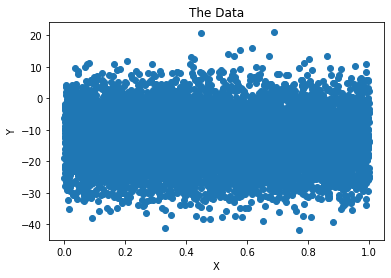

In [179]:
plt.scatter(X,Y)
plt.xlabel("X")
plt.ylabel("Y")
plt.title("The Data")

In [180]:
df
#it accepts every single one?
#does it arrive to the right parameters?
#effect of changing starting point?

,accepted,acceptance_prob,a,b,sigma
0,False,0.000000e+00,0.000000,4.000000,2.000000
1,False,0.000000e+00,0.000000,4.000000,2.000000
2,False,0.000000e+00,0.000000,4.000000,2.000000
3,False,0.000000e+00,0.000000,4.000000,2.000000
4,True,2.718282e+00,-0.076699,3.997009,2.083912
...,...,...,...,...,...
19995,False,3.168638e-02,-0.224422,-12.773409,8.071994
19996,False,7.625550e-60,-0.224422,-12.773409,8.071994
19997,False,2.938490e-06,-0.224422,-12.773409,8.071994
19998,False,8.178347e-01,-0.224422,-12.773409,8.071994


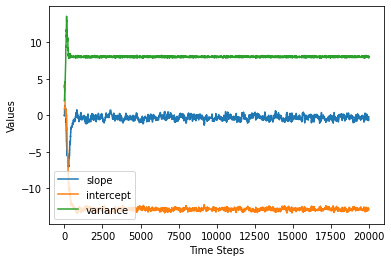

In [181]:
plt.plot(range(len(df)),df['a'], label='slope')
plt.plot(range(len(df)),df['b'], label='intercept')
plt.plot(range(len(df)),df['sigma'], label='variance')
#plt.plot(range(len(df)),df['acceptance_prob'], label='accept_prob')
plt.xlabel("Time Steps")
plt.ylabel("Values")
plt.legend()

(0.0, 1.0)

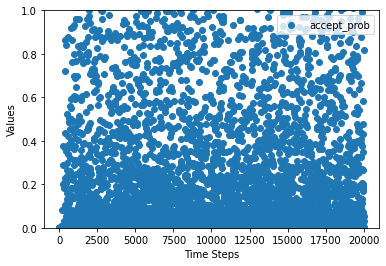

In [182]:
plt.scatter(range(len(df)),df['acceptance_prob'], label='accept_prob')
plt.xlabel("Time Steps")
plt.ylabel("Values")
plt.legend()
ax = plt.gca()
ax.set_ylim([0,1])

In [183]:
df['acceptance_prob'].tolist()

[0.0,
 0.0,
 0.0,
 0.0,
 2.718281828459045,
 2.718281828459045,
 0.0,
 0.0,
 0.0,
 2.718281828459045,
 2.718281828459045,
 0.0,
 0.0,
 2.718281828459045,
 0.0,
 2.718281828459045,
 2.718281828459045,
 2.718281828459045,
 2.718281828459045,
 2.718281828459045,
 2.718281828459045,
 0.0,
 2.718281828459045,
 0.0,
 2.718281828459045,
 0.0,
 2.718281828459045,
 2.718281828459045,
 2.718281828459045,
 0.0,
 0.0,
 0.0,
 2.718281828459045,
 2.718281828459045,
 4.4677448476597045e-249,
 0.0,
 2.718281828459045,
 0.0,
 0.0,
 2.718281828459045,
 2.718281828459045,
 2.718281828459045,
 0.0,
 0.0,
 0.0,
 0.0,
 2.8671264006559592e-126,
 0.0,
 2.718281828459045,
 2.718281828459045,
 2.718281828459045,
 2.718281828459045,
 0.0,
 0.0,
 2.718281828459045,
 0.0,
 0.0,
 2.718281828459045,
 0.0,
 2.718281828459045,
 0.0,
 0.0,
 0.0,
 2.718281828459045,
 2.718281828459045,
 0.0,
 1.712388374732687e-305,
 2.718281828459045,
 0.0,
 2.718281828459045,
 2.718281828459045,
 0.0,
 2.718281828459045,
 0.0,
 2.7182

In [184]:
df.head(50)

,accepted,acceptance_prob,a,b,sigma
0,False,0.000000e+00,0.000000,4.000000,2.000000
1,False,0.000000e+00,0.000000,4.000000,2.000000
2,False,0.000000e+00,0.000000,4.000000,2.000000
3,False,0.000000e+00,0.000000,4.000000,2.000000
4,True,2.718282e+00,-0.076699,3.997009,2.083912
5,True,2.718282e+00,0.076736,3.788077,2.132601
6,False,0.000000e+00,0.076736,3.788077,2.132601
7,False,0.000000e+00,0.076736,3.788077,2.132601
8,False,0.000000e+00,0.076736,3.788077,2.132601
9,True,2.718282e+00,0.827786,4.059769,2.382796


In [185]:
(df['accepted'].sum()/len(df))
#about 1.5% accepted with a 0.5 breadth rate
#about 2.5% accepted with a 0.2 breadth rate
#about 1% accepted with 0.01 breadth rate
#about 0.015% accepted with a 0.001 breadth rate

0.1546

In [186]:
df[df['accepted']]

,accepted,acceptance_prob,a,b,sigma
4,True,2.718282,-0.076699,3.997009,2.083912
5,True,2.718282,0.076736,3.788077,2.132601
9,True,2.718282,0.827786,4.059769,2.382796
10,True,2.718282,0.639546,4.249165,2.475997
13,True,2.718282,0.593373,4.013180,2.458814
...,...,...,...,...,...
19977,True,0.478532,-0.716156,-12.746546,8.001678
19981,True,0.193488,-0.672951,-12.766591,8.163647
19988,True,0.347152,-0.453038,-12.782145,7.873807
19989,True,2.718282,-0.224422,-12.773409,8.071994


## The Larger Case: N(50, 5)

In [ ]:
X = np.random.rand(100)
Y = np.random.normal(4,2,10000)
data = np.vstack((X,Y))
samples = sample(data, 30000, 0, (0,0,1), 1)
df = pd.DataFrame(samples)
df[['a','b','sigma']] = pd.DataFrame(df['theta'].tolist(), index=df.index)
df = df.drop(['theta'], axis=1)

In [ ]:
df

In [ ]:
plt.plot(range(len(df)),df['a'], label='slope')
plt.plot(range(len(df)),df['b'], label='intercept')
plt.plot(range(len(df)),df['sigma'], label='variance')
plt.plot(range(len(df)),df['acceptance_prob'], label='accept_prob')
plt.xlabel("Time Steps")
plt.ylabel("Values")
plt.legend()

In [ ]:
plt.plot(range(len(df)),df['acceptance_prob'], label='accept_prob')
plt.xlabel("Time Steps")
plt.ylabel("Values")
plt.legend()